# Introducción a la Ciencia de Datos: Tarea 1

Este notebook contiene el código de base para realizar la Tarea 1 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://github.com/DonBraulio/introCD).

Se utiliza el lenguaje Python y la librería Pandas. Si no tiene ninguna familiaridad con la librería, se recomienda realizar algún tutorial introductorio (ver debajo).
También se espera que los alumnos sean proactivos a la hora de consultar las documentaciones de las librerías y del lenguaje, para entender el código provisto.
Además de los recursos provistos en la [página del curso](https://eva.fing.edu.uy/course/view.php?id=1378&section=1), los siguientes recursos le pueden resultar interesantes:
 - [Pandas getting started](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) y [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html): Son parte de la documentación en la página oficial de Pandas.
 - [Kaggle Learn](https://www.kaggle.com/learn): Incluye tutoriales de Python y Pandas.


Si desea utilizar el lenguaje R y está dispuesto a no utilizar (o traducir) este código de base, también puede hacerlo.

En cualquier caso, **se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.

## Cargar bibliotecas (dependencias)
Recuerde instalar los requerimientos (`requirements.txt`) en el mismo entorno donde está ejecutando este notebook (ver [README](https://github.com/DonBraulio/introCD)).

In [35]:
from time import time
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from wordcloud import WordCloud
import matplotlib.cm as cm

import math
import numpy as np

import re as re
import seaborn as sns

viridis = cm.get_cmap('viridis')
color1 = viridis(0.25)
color2 = viridis(0.5)

<ipython-input-35-9a7e79a39272>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


## Lectura de Datos

In [36]:
# DataFrame con todas las obras:
df_works = pd.read_csv('../data/shakespeare/works.csv')

# Todos los párrafos de todas las obras
df_paragraphs = pd.read_csv('../data/shakespeare/paragraphs.csv')

# TODO: cargar el resto de las tablas
df_chapters = pd.read_csv('../data/shakespeare/chapters.csv')
df_characters = pd.read_csv('../data/shakespeare/characters.csv')

## Exploración de Datos

In [37]:
print("Characters")
print(df_characters.head()) 
print(df_characters.info())  
print(df_characters.columns)
print("Chapters")
print(df_chapters.head()) 
print(df_chapters.info())  
print(df_chapters.columns)
print("Works")
print(df_works.head())   
print(df_works.info())  
print(df_works.columns)
print("Paragraphs")
print(df_paragraphs.head()) 
print(df_paragraphs.info())  
print(df_paragraphs.columns)

Characters
   Unnamed: 0  id           CharName             Abbrev Description
0           0   1   First Apparition   First Apparition         NaN
1           1   2      First Citizen      First Citizen         NaN
2           2   3  First Conspirator  First Conspirator         NaN
3           3   4    First Gentleman    First Gentleman         NaN
4           4   5         First Goth         First Goth         NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   1266 non-null   int64 
 1   id           1266 non-null   int64 
 2   CharName     1266 non-null   object
 3   Abbrev       1261 non-null   object
 4   Description  620 non-null    object
dtypes: int64(2), object(3)
memory usage: 49.6+ KB
None
Index(['Unnamed: 0', 'id', 'CharName', 'Abbrev', 'Description'], dtype='object')
Chapters
   Unnamed: 0     id  Act  Scene          

In [38]:
#----- Otras verificaciones ------

# Verificar que los ID sean unicos
print(df_characters['id'].is_unique)
print(df_chapters['id'].is_unique)
print(df_works['id'].is_unique)
print(df_paragraphs['id'].is_unique)

# Consistencia en referencias entre tablas
if not df_paragraphs['character_id'].isin(df_characters['id']).all():
    print ('Hay incoherencia entre character_id en Paragraphs con id en Characters')
    
if not df_paragraphs['chapter_id'].isin(df_chapters['id']).all():
    print ('Hay incoherencia entre chapter_id en Paragraphs con id en Chapters')
    
if not df_chapters['work_id'].isin(df_works['id']).all():
    print ('Hay incoherencia entre work_id en Chapters con id en Works')
    
else:
    print('Hay coherencia en referencia entre tablas')

# Filas duplicadas

print(df_works.duplicated().sum())
#print(df_paragraphs.duplicated().sum())
print(df_chapters.duplicated().sum())
print(df_characters.duplicated().sum())


True
True
True
True
Hay coherencia en referencia entre tablas
0
0
0


Comentarios de las tablas:

Characters. Tiene los personajes de todas las obras de Shakespeare. Tiene un ID para cada personaje y una abreviación así como la descripción. Tiene 1266 entradas, en general están bastante completas salvo la columna descripción que le faltan la mitad de valores aprox.

Chapters. Tiene los capítulos y escenas de todas las obras de Shakespeare. Tiene un ID para cada capútlo-escena y una abreviación así como una descripción de la misma y un work_Id, que debe relacionarse con la tabla works indicando de que obra se trata. Tiene 945 entradas, y no falta ningún dato.

Works. Tiene el nombre de las obras de Shakespeare, en versión corta y larga. Tiene un ID para cada obra que debe relacionarse con el que apareció en chapters así como el año de la misma y el género. Tiene 43 entradas, y no falta ningún dato.

Paragraphs. Tiene información de todos los párrafos de las obras de Shakespeare, incluyendo todo el texto y una numeración. Tiene un ID para cada personaje que se debe relacionar con los datos de characters y para cada capítulo que se deben relacionar con los datos en capítulos. Tiene 35465 entradas, y no falta ningún dato.

In [39]:
conteo_parrafos=df_paragraphs.groupby('character_id').size()
print(conteo_parrafos.max())
print(conteo_parrafos.idxmax())
print(df_characters[df_characters['id']==conteo_parrafos.idxmax()]['CharName'].values[0])

#Como (stage directions) no es un personaje, miramos el segundo con mas parrafos
print(conteo_parrafos.nlargest(2))
second_largest=conteo_parrafos.nlargest(2).values[1]
id_second=conteo_parrafos[conteo_parrafos==second_largest].index.values[0]
print(df_characters[df_characters['id']==id_second]['CharName'].values[0])



3751
1261
(stage directions)
character_id
1261    3751
894      733
dtype: int64
Poet


El character_id con mas parrafos es el que se corresponde con "(stage directions)". El personaje con mas parrafos es "Poet".

GenreType  Comedy  History  Poem  Sonnet  Tragedy
Date                                             
1589            1        0     0       0        0
1590            0        2     0       0        0
1591            0        1     0       0        0
1592            0        1     0       0        0
1593            1        0     1       0        1
1594            2        0     1       0        1
1595            1        1     0       0        0
1596            1        1     0       0        0
1597            0        2     0       0        0
1598            1        1     1       0        0
1599            2        0     0       0        1
1600            1        0     0       0        1
1601            0        0     1       0        1
1602            1        0     0       0        0
1603            0        0     0       0        0
1604            1        0     0       0        1
1605            0        0     0       0        2
1606            0        0     0       0        1


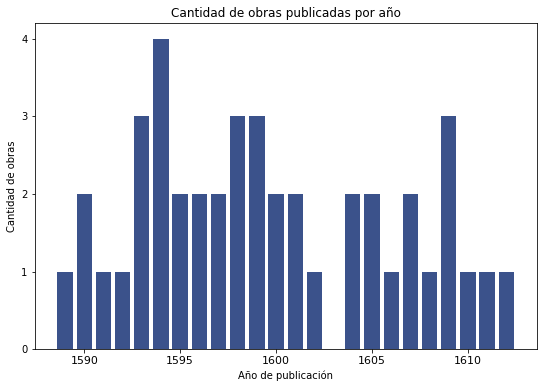

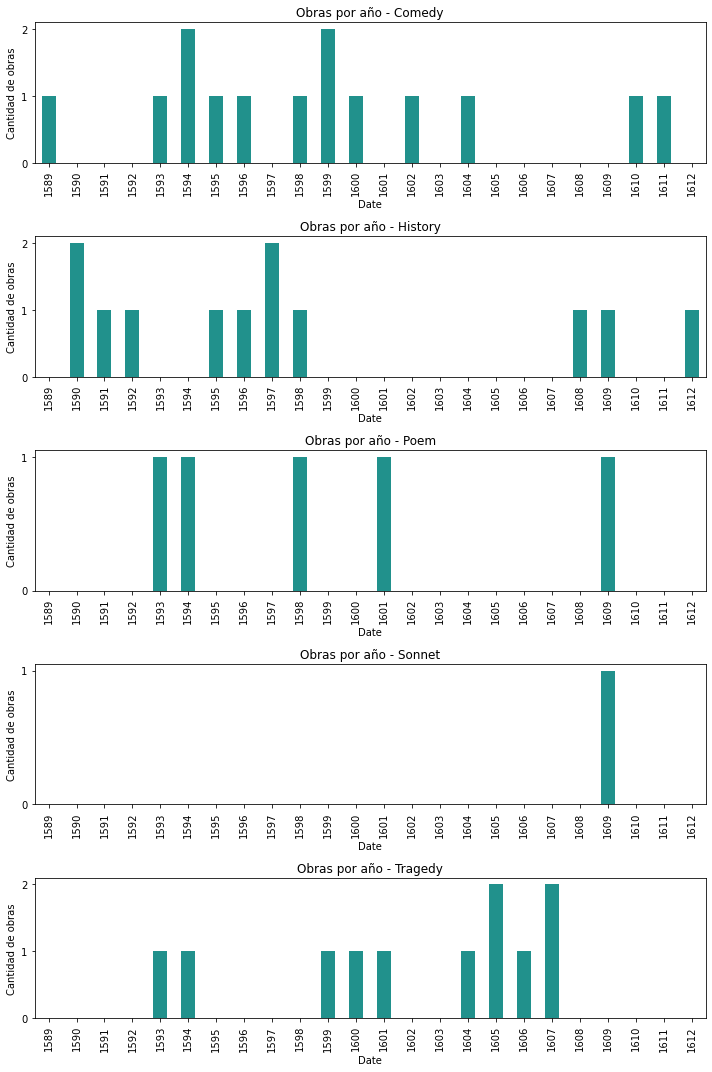

In [40]:
obras=df_works.groupby('Date').size()

plt.figure(figsize=(9, 6))
plt.bar(obras.index, obras.values, color=color1) 
plt.title('Cantidad de obras publicadas por año')
plt.xticks(fontsize=11)
plt.xlabel('Año de publicación')
plt.ylabel('Cantidad de obras')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))


obras_ano_genero=df_works.groupby(['Date', 'GenreType']).size().unstack(fill_value=0)
completar_indices = range(obras_ano_genero.index.min(), obras_ano_genero.index.max() + 1)
obras_ano_genero = obras_ano_genero.reindex(completar_indices, fill_value=0)
print(obras_ano_genero)

numero_generos = len(obras_ano_genero.columns)

# Crear figura para los subplots
plt.figure(figsize=(10, 3 * numero_generos))

# Iterar sobre cada columna (género) para crear un subplot
for i, genre in enumerate(obras_ano_genero.columns):
    ax = plt.subplot(numero_generos, 1, i + 1)  # Crear un subplot para cada género
    obras_ano_genero[genre].plot(kind='bar', ax=ax, color=color2)
    ax.set_title(f'Obras por año - {genre}')
    #ax.set_xlabel('Año de publicación')
    ax.set_ylabel('Cantidad de obras')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()



            Comedy History Poem Sonnet Tragedy  Total
1589 a 1592      1       4    0      0       0    5.0
1593 a 1596      5       2    2      0       2   11.0
1597 a 1600      4       3    1      0       2   10.0
1601 a 1604      2       0    1      0       2    5.0
1605 a 1608      0       1    0      0       5    6.0
1609 a 1612      2       2    1      1       0    6.0


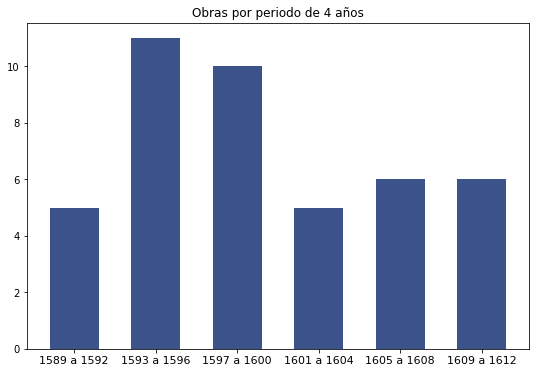

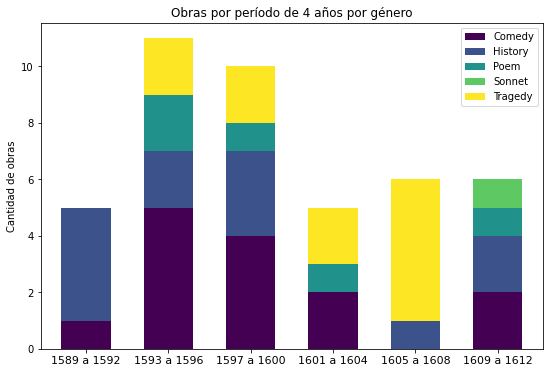

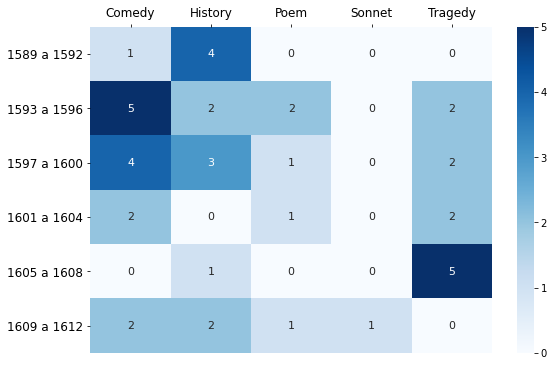

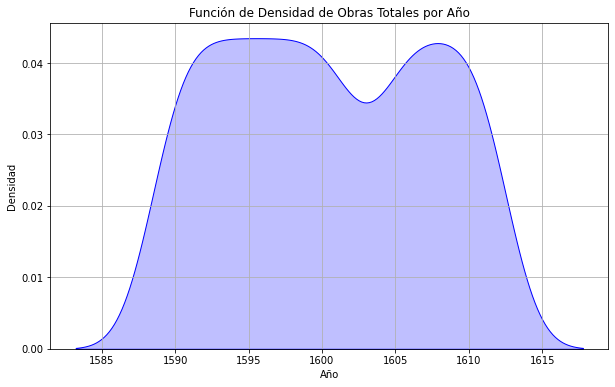

In [41]:
#-- Agrupadas por periodos de x años ---
obras=df_works.groupby('Date').size()
periodo=obras.index.max()-obras.index.min()
anios=list(range(obras.index.min(),obras.index.max()+1))
hueco=[a for a in anios if a not in obras.index]

intervalo=4 #ver cual queda mejor
tot_inter = (obras.index.max() - obras.index.min()) // intervalo + 1
cant_obras=[]
ejex=[]
bins=[[x,x+intervalo] for x in range(obras.index.min(),obras.index.min()+tot_inter*intervalo,intervalo)]

#Defino df con el acumulado cada intervalo anios

columns=obras_ano_genero.columns.tolist()
period=['{} a {}'.format(b[0],b[1]-1) for b in bins]
obras_periodo=pd.DataFrame(data=None, index=period, columns=columns)

for b in bins:
    obras_periodo.iloc[bins.index(b),:]=obras_ano_genero.iloc[bins.index(b)*intervalo:(bins.index(b)+1)*intervalo,:].sum()

obras_periodo['Total']=obras_periodo.sum(axis=1)

print(obras_periodo)


plt.figure(figsize=(9, 6))
plt.bar(obras_periodo.index,obras_periodo['Total'].values, color=color1,width=0.6)
plt.title('Obras por periodo de {} años'.format(intervalo))
plt.xticks(fontsize=11)


obras_periodo.iloc[:,:-1].plot(kind='bar', stacked=True,
        title='Obras por período de {} años por género'.format(intervalo),figsize=(9,6),width=0.6,colormap='viridis')
plt.xlabel(' ')
plt.ylabel('Cantidad de obras')
plt.xticks(rotation=0,fontsize=11)


# Convert all columns to numeric
obras_periodo = obras_periodo.apply(pd.to_numeric, errors='coerce')

# Drop rows or columns that contain only NaN values
obras_periodo = obras_periodo.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Generate the heatmap using seaborn
plt.figure(figsize=(9, 6))
ax=sns.heatmap(obras_periodo.iloc[:,:-1], annot=True, cmap='Blues',cbar=True, xticklabels=True, yticklabels=True,annot_kws={"size": 11})
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Crear la gráfica de densidad
plt.figure(figsize=(10, 6))
sns.kdeplot(data=obras.values, x=obras.index, bw_adjust=0.5, fill=True, color='blue')
plt.title('Función de Densidad de Obras Totales por Año')
plt.xlabel('Año')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

In [42]:
df_paragraphs["PlainText"]

0        [Enter DUKE ORSINO, CURIO, and other Lords; Mu...
1        If music be the food of love, play on;\r\nGive...
2                               Will you go hunt, my lord?
3                                             What, Curio?
4                                                The hart.
                               ...                        
35460    That she is living,\r\nWere it but told you, s...
35461    You gods, look down\r\nAnd from your sacred vi...
35462    There's time enough for that;\r\nLest they des...
35463    O, peace, Paulina!\r\nThou shouldst a husband ...
35464                                             [Exeunt]
Name: PlainText, Length: 35465, dtype: object

## Limpieza de Texto y Conteo de Palabras

In [43]:
def clean_text(df, column_name):
    # Convertir todo a minúsculas
    result = df[column_name].str.lower()

    # Quitar signos de puntuación y cambiarlos por espacios (" ")
    # TODO: completar signos de puntuación faltantes
    for punc in ["[", "\n", ",",";",":","!","?","-","'","."]:
        result = result.str.replace(punc, " ")
    return result

# Creamos una nueva columna CleanText a partir de PlainText
df_paragraphs["CleanText"] = clean_text(df_paragraphs, "PlainText")

# Veamos la diferencia
df_paragraphs[["PlainText", "CleanText"]]

<ipython-input-43-ddc776e88e00>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  result = result.str.replace(punc, " ")


,PlainText,CleanText
0,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",enter duke orsino curio and other lords mu...
1,"If music be the food of love, play on;\r\nGive...",if music be the food of love play on \r give ...
2,"Will you go hunt, my lord?",will you go hunt my lord
3,"What, Curio?",what curio
4,The hart.,the hart
...,...,...
35460,"That she is living,\r\nWere it but told you, s...",that she is living \r were it but told you sh...
35461,"You gods, look down\r\nAnd from your sacred vi...",you gods look down\r and from your sacred via...
35462,There's time enough for that;\r\nLest they des...,there s time enough for that \r lest they desi...
35463,"O, peace, Paulina!\r\nThou shouldst a husband ...",o peace paulina \r thou shouldst a husband t...


In [44]:
# Convierte párrafos en listas "palabra1 palabra2 palabra3" -> ["palabra1", "palabra2", "palabra3"]
df_paragraphs["WordList"] = df_paragraphs["CleanText"].str.split()

# Veamos la nueva columna creada
# Notar que a la derecha tenemos una lista: [palabra1, palabra2, palabra3]
df_paragraphs[["CleanText", "WordList"]]

,CleanText,WordList
0,enter duke orsino curio and other lords mu...,"[enter, duke, orsino, curio, and, other, lords..."
1,if music be the food of love play on \r give ...,"[if, music, be, the, food, of, love, play, on,..."
2,will you go hunt my lord,"[will, you, go, hunt, my, lord]"
3,what curio,"[what, curio]"
4,the hart,"[the, hart]"
...,...,...
35460,that she is living \r were it but told you sh...,"[that, she, is, living, were, it, but, told, y..."
35461,you gods look down\r and from your sacred via...,"[you, gods, look, down, and, from, your, sacre..."
35462,there s time enough for that \r lest they desi...,"[there, s, time, enough, for, that, lest, they..."
35463,o peace paulina \r thou shouldst a husband t...,"[o, peace, paulina, thou, shouldst, a, husband..."


In [45]:
print(df_paragraphs["CleanText"])
### este codigo busca todos los signos de puntuación en el df y luego voy a la función clean text y borro los que aparecen hasta que esté vacío
def find_punctuation(text):
    return re.findall(r'[^\w\s]', text)

df_paragraphs['Punctuations'] = df_paragraphs['CleanText'].apply(find_punctuation)
print(df_paragraphs)

0         enter duke orsino  curio  and other lords  mu...
1        if music be the food of love  play on \r give ...
2                               will you go hunt  my lord 
3                                             what  curio 
4                                                the hart 
                               ...                        
35460    that she is living \r were it but told you  sh...
35461    you gods  look down\r and from your sacred via...
35462    there s time enough for that \r lest they desi...
35463    o  peace  paulina \r thou shouldst a husband t...
35464                                              exeunt]
Name: CleanText, Length: 35465, dtype: object
       Unnamed: 0      id  ParagraphNum  \
0               0  630863             3   
1               1  630864             4   
2               2  630865            19   
3               3  630866            20   
4               4  630867            21   
...           ...     ...           ...   
3546

            word  count
21698        the  28901
797          and  27282
10960          i  23006
22019         to  20820
14810         of  17161
...          ...    ...
12176     lacked      1
12179  lackeying      1
12186   ladders]      1
12187       lade      1
24916    zwagger      1

[24917 rows x 2 columns]


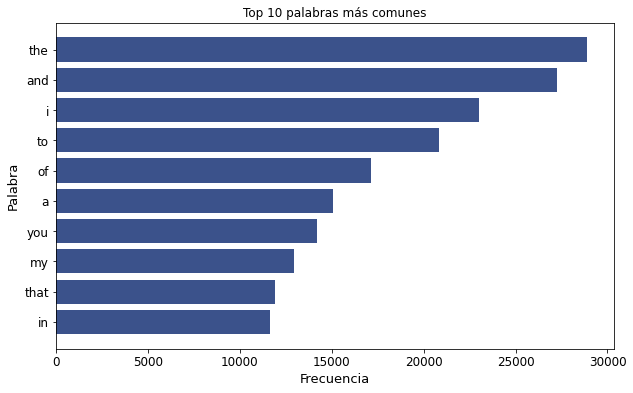

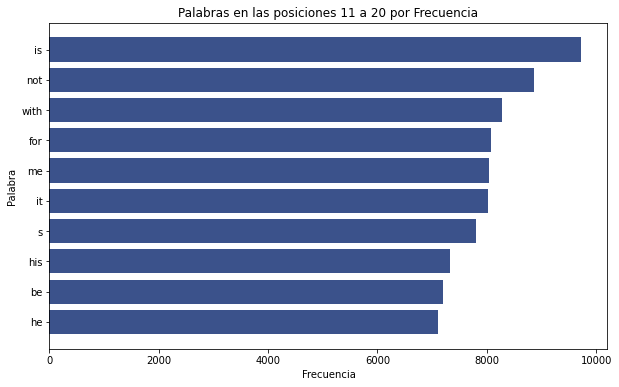

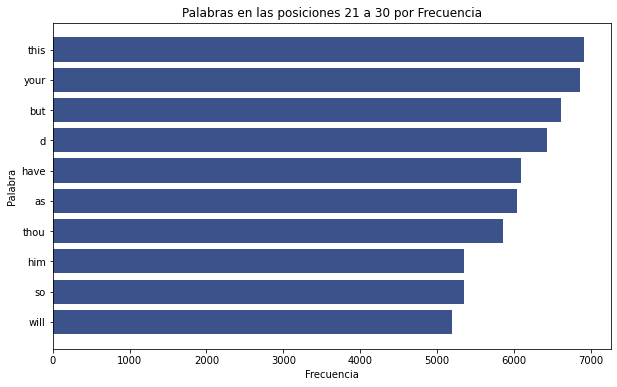

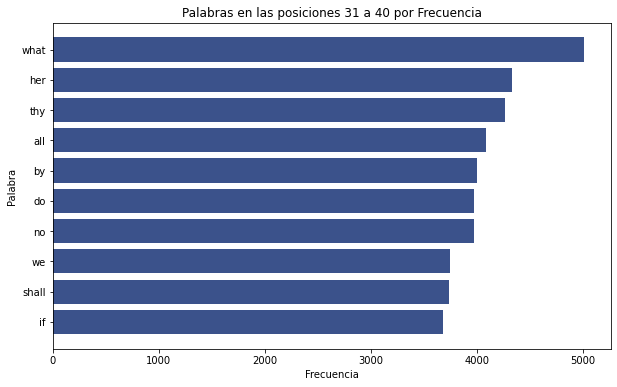

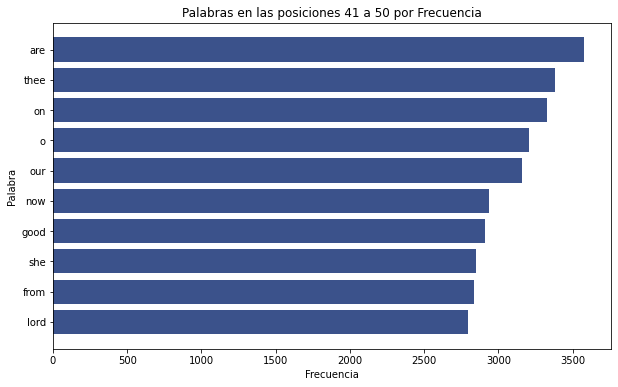

In [46]:
# Nuevo dataframe: cada fila ya no es un párrafo, sino una sóla palabra
df_words = df_paragraphs.explode("WordList")

# Quitamos estas columnas redundantes
df_words.drop(columns=["CleanText", "PlainText"], inplace=True)

# Renombramos la columna WordList -> word
df_words.rename(columns={"WordList": "word"}, inplace=True)

# Verificar que el número de filas es mucho mayor
df_words

word_counts = df_words.groupby('word').size()

word_counts_df = word_counts.reset_index(name='count')
word_counts_df = word_counts_df.sort_values(by='count', ascending=False)

print(word_counts_df)

plt.figure(figsize=(10, 6))
plt.barh(word_counts_df['word'].head(10), word_counts_df['count'].head(10), color=color1)
plt.gca().invert_yaxis() 
plt.xlabel('Frecuencia', fontsize=13)
plt.ylabel('Palabra', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Top 10 palabras más comunes')

plt.figure(figsize=(10, 6))
plt.barh(word_counts_df['word'].iloc[10:20], word_counts_df['count'].iloc[10:20], color=color1)
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Palabras en las posiciones 11 a 20 por Frecuencia')
plt.gca().invert_yaxis()  # Para que la palabra más frecuente en este rango aparezca arriba
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(word_counts_df['word'].iloc[20:30], word_counts_df['count'].iloc[20:30], color=color1)
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Palabras en las posiciones 21 a 30 por Frecuencia')
plt.gca().invert_yaxis()  # Para que la palabra más frecuente en este rango aparezca arriba
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(word_counts_df['word'].iloc[30:40], word_counts_df['count'].iloc[30:40], color=color1)
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Palabras en las posiciones 31 a 40 por Frecuencia')
plt.gca().invert_yaxis()  # Para que la palabra más frecuente en este rango aparezca arriba
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(word_counts_df['word'].iloc[40:50], word_counts_df['count'].iloc[40:50], color=color1)
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Palabras en las posiciones 41 a 50 por Frecuencia')
plt.gca().invert_yaxis()  # Para que la palabra más frecuente en este rango aparezca arriba
plt.show()


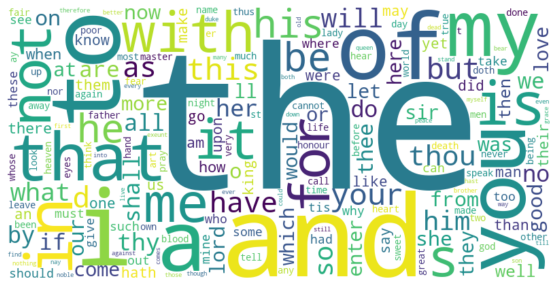

In [15]:
#Wordcloud
word_freq = dict(zip(word_counts_df['word'], word_counts_df['count']))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Quitar los ejes
plt.show()

 ## Personajes con mayor cantidad de palabras

In [47]:
# Agregamos el nombre de los personajes
# TODO: des-comentar luego de cargar df_characters
df_words = pd.merge(df_words, df_characters[["id", "CharName"]], left_on="character_id", right_on="id")

In [48]:
# TODO:
# - des-comentar luego de hacer el merge
# - Encuentra algún problema en los resultados?

words_per_character = df_words.groupby("CharName")["word"].count().sort_values(ascending=False)
print(words_per_character)
#Aparace (stage directions como character name)


df_filtered = df_words[df_words['CharName'] != "(stage directions)"]
words_per_character = df_filtered.groupby("CharName")["word"].count().sort_values(ascending=False)

print(words_per_character)

CharName
Poet                  50768
(stage directions)    16583
Henry V               15429
Falstaff              14908
Hamlet                12314
                      ...  
Philip                    3
Nicholas                  2
Joseph                    2
Taurus                    2
Thieves                   1
Name: word, Length: 925, dtype: int64
CharName
Poet                  50768
Henry V               15429
Falstaff              14908
Hamlet                12314
Duke of Gloucester     9526
                      ...  
Ostler                    3
Nicholas                  2
Taurus                    2
Joseph                    2
Thieves                   1
Name: word, Length: 924, dtype: int64


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Poet'),
  Text(0, 1, 'Henry V'),
  Text(0, 2, 'Falstaff'),
  Text(0, 3, 'Hamlet'),
  Text(0, 4, 'Duke of Gloucester'),
  Text(0, 5, 'Antony'),
  Text(0, 6, 'Iago'),
  Text(0, 7, 'Henry IV'),
  Text(0, 8, 'Vincentio'),
  Text(0, 9, 'Henry VI')])

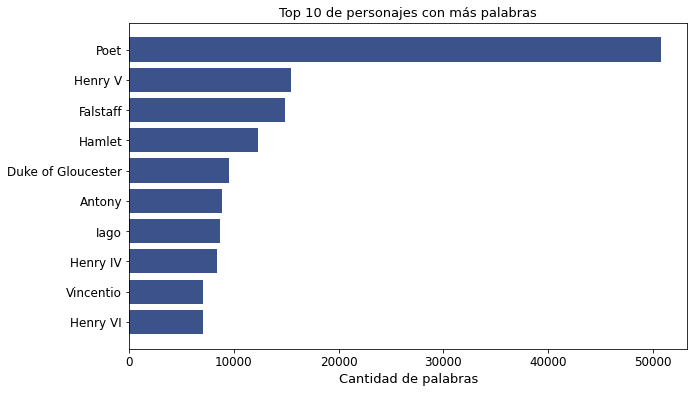

In [49]:
# Ejemplo: 10 personajes con más palabras
char_show = words_per_character[:10]
plt.figure(figsize=(10, 6))
plt.barh(char_show.index, char_show.values, color=color1)
plt.gca().invert_yaxis()
plt.xlabel('Cantidad de palabras', fontsize=13)
plt.title('Top 10 de personajes con más palabras', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)